In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
sys.path.append('..')
from audio import *

In [24]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

## Introduction

This is the final notebook for the googlespeech competition. We will generate algorithmic silence, pseudolabel our test set as a form of semi-supervised learning, use it to fine tune both our models, and then ensemble them for final predictions.

In [25]:
PATH_BASE = Path('../data/google_speech/')
PATH_TEST = PATH_BASE/'test/audio/'
PATH_DATA = PATH_BASE/'train/audio/'

### Algorithmically generating our own silence examples

First we load up our config, the test set, and predictions from the mfcc. We also recreate `confidence_list` which is a list of tuples of the items, their predicted label, and how strongly the model predicted that label

In [31]:
sg_cfg= SpectrogramConfig(hop=72, f_max=8000, top_db=80, f_min=20)
cfg = AudioConfig(cache=True, max_to_pad=None, mfcc=True, delta=True, sg_cfg=sg_cfg)
test = AudioList.from_folder(PATH_TEST, config=cfg); test
classes = ['down','go','left','no','off','on','right','silence','stop','unknown','up', 'yes']
with open('mfcc_preds.pkl', 'rb') as f:
    preds_list = pickle.load(f)
confidence_list = []
for idx, item in enumerate(test):
    confidence = torch.max(preds_list[idx]).item()
    label = classes[torch.argmax(preds_list[idx])]
    confidence_list.append((item, label, confidence))

So the training set has very simple "silence" but the test set has lots of examples that are completely different, including some that are pure zeros that seem like the easiest form of silence, but are actually being labeled as "unknown" by our model. Let's listen to a few. As you can hear they have a less constant and more warbly sound to them, which seems 

In [32]:
possibly_silence = [x for x in confidence_list if x[1] in ['unknown', 'silence'] and x[2] < 0.8]
definitely_silence = [x for x in confidence_list if x[1] == 'silence' and x[2] > 0.95]
len(possibly_silence), len(definitely_silence)

(16758, 6486)

First we look at items that the model is 95% + confident are silence. It turns out about half of them are words are noisy backgrounds. MFCC's don't handle noise well. One approach I've heard mentioned is taking an exponent (2nd or 3rd) of the spectrogram before taking the DCT (discrete cosine transform, the distinctive feature of an mfcc) to combat noise, but we don't offer this feature, I'm just mentioning it in case you really need to use MFCC w noisy samples. 

In [ ]:
for item, label, confidence in definitely_silence[0:20]:
    item.show()
    print("Path:", item.path)
    print("Label:", label)
    print("Conf.:", round(100*confidence, 2))
    print("-"*70)

Next we see that half of these are noisy silence that is just so unlike our training silence, that we can't predict it and it is being labeled as unknown, but the good news is we've found a pattern and from here we can work on fixing it.

In [33]:
for item, label, confidence in possibly_silence[0:20]:
    item.show()
    print("Path:", item.path)
    print("Label:", label)
    print("Conf.:", round(100*confidence, 2))
    print("-"*70)

File: ../data/google_speech/test/audio/clip_78befd0e0.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_78befd0e0.wav
Label: unknown
Conf.: 57.32
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_0e7824991.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_0e7824991.wav
Label: unknown
Conf.: 54.98
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_7452d0401.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_7452d0401.wav
Label: unknown
Conf.: 63.37
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_617613691.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_617613691.wav
Label: unknown
Conf.: 58.36
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_99e3ada5b.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_99e3ada5b.wav
Label: unknown
Conf.: 60.98
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_7e5a93de5.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_7e5a93de5.wav
Label: unknown
Conf.: 30.54
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_71c72fada.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_71c72fada.wav
Label: unknown
Conf.: 73.68
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_9fb0fc724.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_9fb0fc724.wav
Label: unknown
Conf.: 61.38
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_ed9415390.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_ed9415390.wav
Label: unknown
Conf.: 69.61
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_19333de3e.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_19333de3e.wav
Label: unknown
Conf.: 51.08
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_600f3b64e.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_600f3b64e.wav
Label: unknown
Conf.: 60.98
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_7974e0bd3.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_7974e0bd3.wav
Label: unknown
Conf.: 60.6
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_7d643c9a0.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_7d643c9a0.wav
Label: unknown
Conf.: 60.16
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_6052b8866.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_6052b8866.wav
Label: unknown
Conf.: 64.91
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_2f86e62e9.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_2f86e62e9.wav
Label: unknown
Conf.: 73.52
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_ba092a3d4.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_ba092a3d4.wav
Label: unknown
Conf.: 68.61
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_db6431601.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_db6431601.wav
Label: unknown
Conf.: 68.65
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_a28394a97.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_a28394a97.wav
Label: unknown
Conf.: 74.15
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_1afa37827.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_1afa37827.wav
Label: unknown
Conf.: 60.77
----------------------------------------------------------------------
File: ../data/google_speech/test/audio/clip_4f69ec0e4.wav
Total Length: 1.0 seconds


Shape: 20x223


Shape: 20x223


Shape: 20x223
Path: ../data/google_speech/test/audio/clip_4f69ec0e4.wav
Label: unknown
Conf.: 68.5
----------------------------------------------------------------------


First we are going to use an open-source library called [colorednoise](https://github.com/felixpatzelt/colorednoise) that was developed by a data scientist named [Felix Patzelt](https://github.com/felixpatzelt). It allows you to use one simple function to create white, brown, pink and other [colors of noise](https://en.wikipedia.org/wiki/Colors_of_noise). I'm not going to discuss noise color as it's not super relevant beyond that some of these have similar profiles to background noise you could expect in your dataset. Let's install the library.

In [46]:
! pip install colorednoise

  Stored in directory: /home/jupyter/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


There's really only one function we need. `powerlaw_psd_gaussian` will take an exponent (this is how we choose the noise color, 0 is white, 1 is pink, 2 is brown, -1 is blue, -2 is violet), and a number of samples, in our case 16000, which is 1s at our sample rate. Partial exponents are also possible, so if you try 0.5, it will be somewhere between white and pink noise. 

In [82]:
import colorednoise as cn
colors = ['white', 'pink', 'brown']
for exponent, color in enumerate(colors):
    y = cn.powerlaw_psd_gaussian(exponent=exponent, size=16000)
    print(color, "noise:")
    display(Audio(y, rate=16000))
    print('-'*70)

white noise:


----------------------------------------------------------------------
pink noise:


----------------------------------------------------------------------
brown noise:


----------------------------------------------------------------------


Partial exponents are also possible, so if you try 0.5, it will be somewhere between white and pink noise.

In [83]:
y = cn.powerlaw_psd_gaussian(exponent=0.5, size=16000)
print("white-pink noise:")
display(Audio(y, rate=16000))


white-pink noise:


 I have no idea how much sounds like that occur in nature, and I'm worried they might be useless to include. We could use a beta distribution, but let's keep it even simpler and do something like 250 clips each of pure white/pink/brown and 100 in between each.

In [117]:
for exponent, color in enumerate(colors):
    sr = 16000
    for i in range(250):
        y = cn.powerlaw_psd_gaussian(exponent=exponent, size=16000)
        savepath = str(PATH_DATA/f'silence/{color}_noise_{i}.wav')
        librosa.output.write_wav(savepath, y, 16000)
    for i in range(100):
        y = cn.powerlaw_psd_gaussian(exponent=exponent+random.random(), size=16000)
        savepath = str(PATH_DATA/f'silence/{color}_plus_noise_{i}.wav')
        librosa.output.write_wav(savepath, y, 16000)

In [124]:
y, sr = torchaudio.load(PATH_DATA/f'silence/white_noise_42.wav')
display(Audio(y, rate=sr))
y, sr = torchaudio.load(PATH_DATA/f'silence/pink_plus_noise_1.wav')
display(Audio(y, rate=sr))

In [133]:
y = cn.powerlaw_psd_gaussian(exponent=0.7752121352, size=16000)
display(Audio(y, rate=sr))

In [38]:
def fft_and_display(path):
    signal, sr = librosa.load(path, sr=16000)
    display(Audio(signal, rate=sr))
    ft = scipy.fftpack.fft(signal, n=len(signal))
    ft = ft[:len(signal)//2+1]
    ft_mag = np.absolute(ft)
    f = np.linspace(0, sr/2, len(ft_mag)) # frequency variable
    plt.figure(figsize=(13, 5))
    plt.plot(f, ft_mag) # magnitude spectrum
    plt.xlabel('Frequency (Hz)')

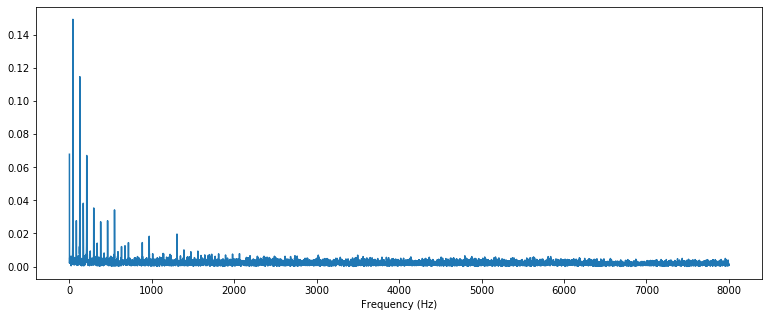

In [39]:
fft_and_display('../data/google_speech/test/audio/clip_78befd0e0.wav')

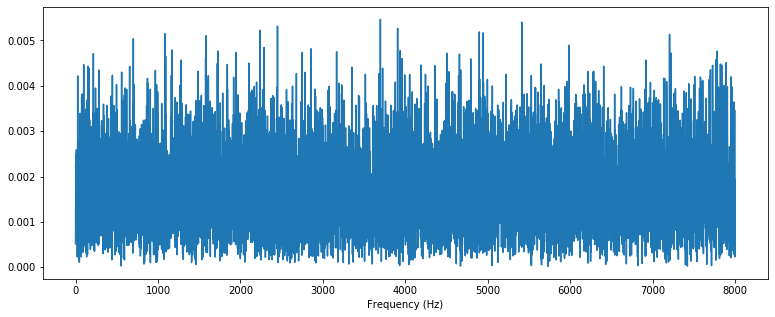

In [43]:
fft_and_display('../data/google_speech/test/audio/clip_7452d0401.wav')

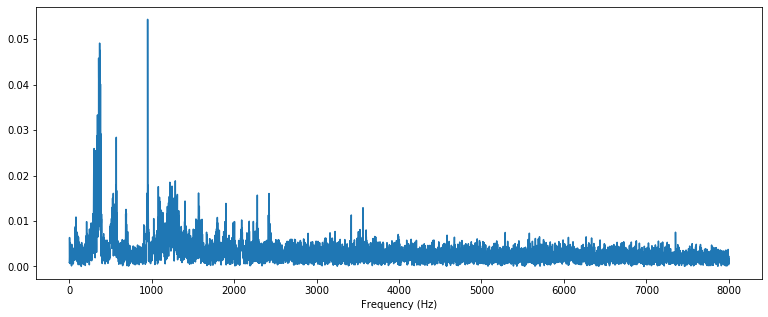

In [44]:
fft_and_display('../data/google_speech/test/audio/clip_71c72fada.wav')

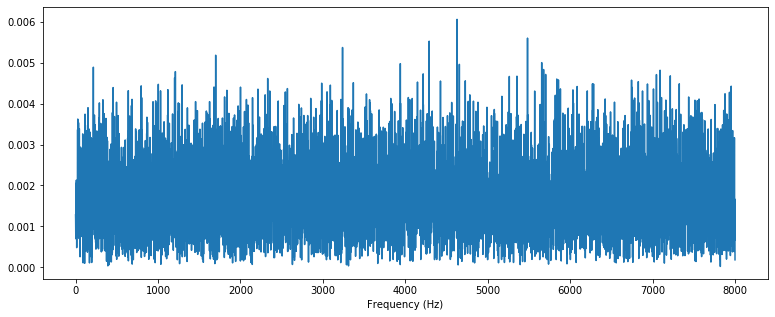

In [45]:
fft_and_display('../data/google_speech/test/audio/clip_7d643c9a0.wav')

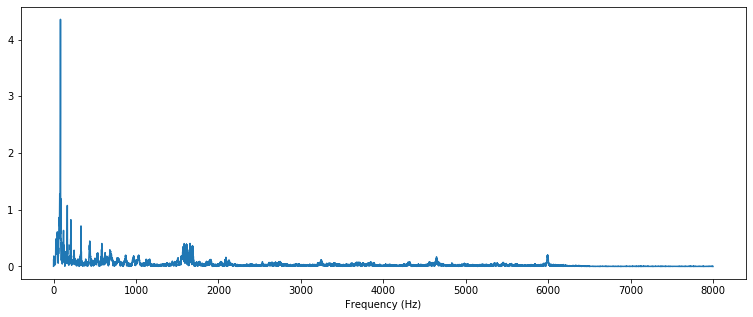

In [46]:
fft_and_display('../data/google_speech/test/audio/clip_db6431601.wav')

Let's also bring back our make_tone function from the audio guide, the example below actually sounds like the background hum of the sound above.

In [55]:
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)

In [56]:
Audio(make_tone(80), rate=16000)

But for the others, we are going to need some more complex combinations. 

In [ ]:
def get_labels_from_file(filename, DF):
    return DF.loc[DF['fname'] == filename].labels.item()